In [3]:
%matplotlib inline

from __future__ import division
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from matplotlib import rc
rc('savefig', dpi=100)

from pyhsmm.util.text import progprint_xrange
from pyhsmm.util.stats import whiten, diag_whiten
import autoregressive.models as models
import autoregressive.distributions as distributions

import flyball.load as load

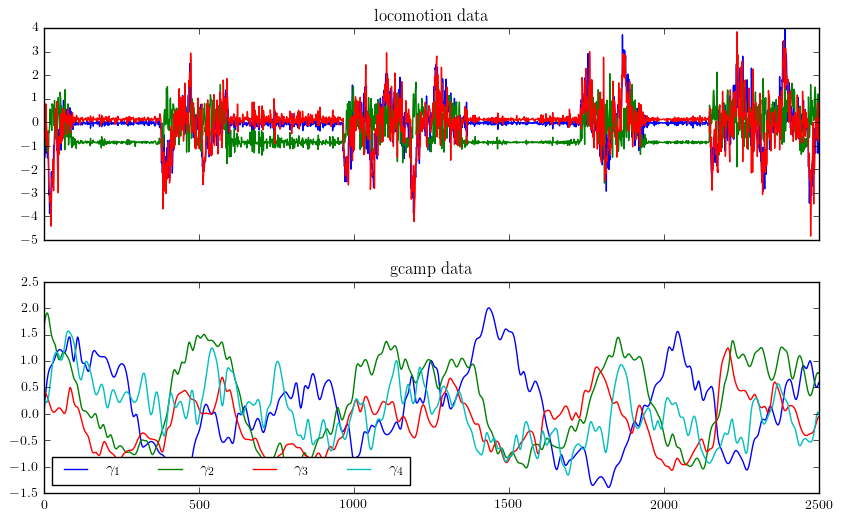

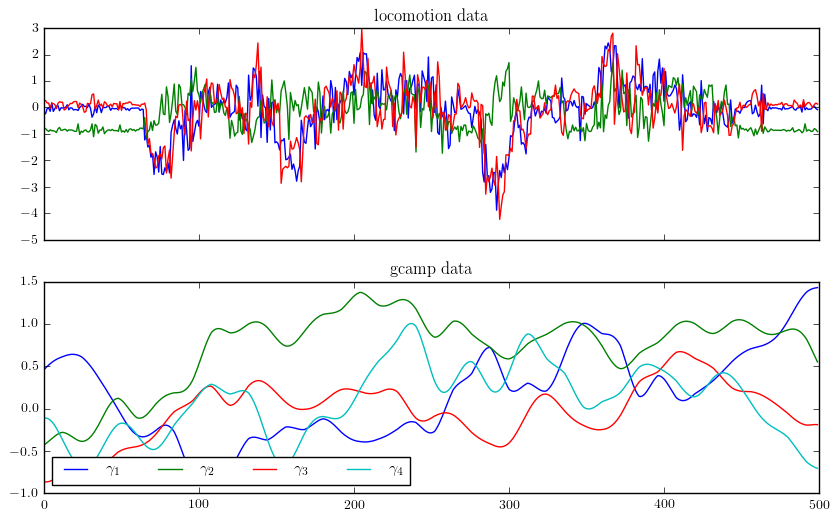

In [4]:
reload(load)

data = diag_whiten(load.load())
gcamp_data, locomotion_data = load.split_data(data)

load.plot_data(data[:2500])
load.plot_data(data[900:1400])

### apply an AR-HMM to the locomotion data

In [8]:
Nmax = 5
affine = True
nlags = 10
ndim = locomotion_data.shape[1]
num_seqs = 8

model = models.FastARWeakLimitStickyHDPHMM(
    alpha=1., gamma=1., init_state_distn='uniform',
    kappa=1e5,
    obs_distns=[
        distributions.AutoRegression(
            nu_0=ndim+1,
            S_0=np.eye(ndim),
            M_0=np.zeros((ndim, ndim*nlags+affine)),
            K_0=np.eye(ndim*nlags+affine),
            affine=affine)
        for state in range(Nmax)])

for d in np.array_split(locomotion_data, num_seqs):
    model.add_data(d)

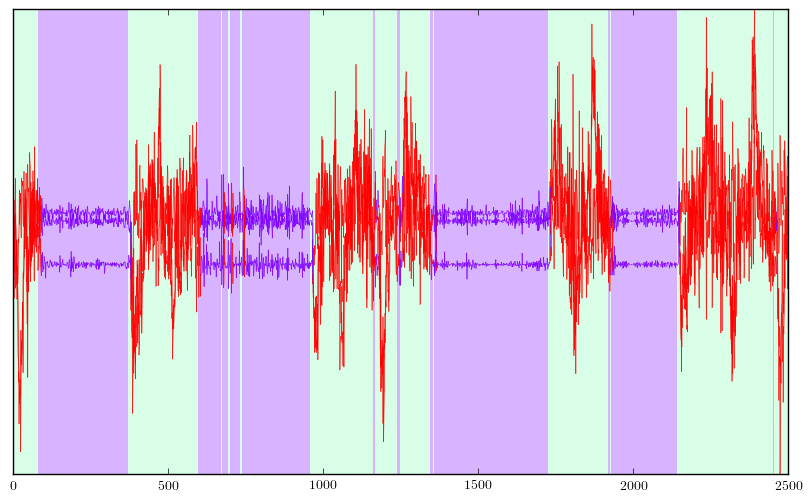

In [9]:
from moviepy.video.io.bindings import mplfig_to_npimage
from moviepy.editor import VideoClip

num_plots = 1
plot_slice = slice(0, 2500)

plt.set_cmap('rainbow')
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6))
axes = axes if num_plots > 1 else [axes]
for s, ax in zip(model.states_list, axes):
    model.plot_stateseq(s, ax=ax, draw=False, plot_slice=plot_slice)
ax = plt.gca()

def make_frame_mpl(t):
    model.resample_model()
    for s, ax in zip(model.states_list, axes):
        model.plot_stateseq(s, ax=ax, update=True, draw=False, plot_slice=plot_slice)
    return mplfig_to_npimage(fig)

anim = VideoClip(make_frame_mpl, duration=5)
anim.ipython_display(fps=30)